# APS360 Final Project: Covid Mask Detector

### Names: Edwin Zhang, Lance Canlas, Stefano Katsoras, Marie Joy Cuevas

##### Description/Info/whaterver: 
placeholder

## Global Imports

In [105]:
#Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os


## Loading Our Data

Split the data set into 60% train, 20% valdation, 20% test

In [112]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

#Master dataset
master = torchvision.datasets.ImageFolder('data', transform = transform)

#split indexes
train_size = int(0.6 * len(master))
val_size = int(0.2 *len(master))
test_size = len(master) - val_size - train_size

train_set, val_set, test_set = torch.utils.data.random_split(master, [train_size, val_size, test_size])
print ("Length of training set: {}".format(len(train_set)))
print ("Length of val set: {}".format(len(val_set)))
print ("Length of test set: {}".format(len(test_set)))

Length of training set: 2349
Length of val set: 783
Length of test set: 784


In [96]:
def display_data (data_loader):
    '''
    Displays a few images to see if our data loaded properly
    
    data_loader: torch data_loader
    data_type: a string to show which data is displayed
    '''

    classes = ['Mask', 'No Mask']

    data = iter(data_loader)
    image, label = data.next()
    npImages = image.numpy() 
    
    # plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(npImages[i], (1, 2, 0)))
        ax.set_title(classes[label[i]])

#### Check Our Training Data

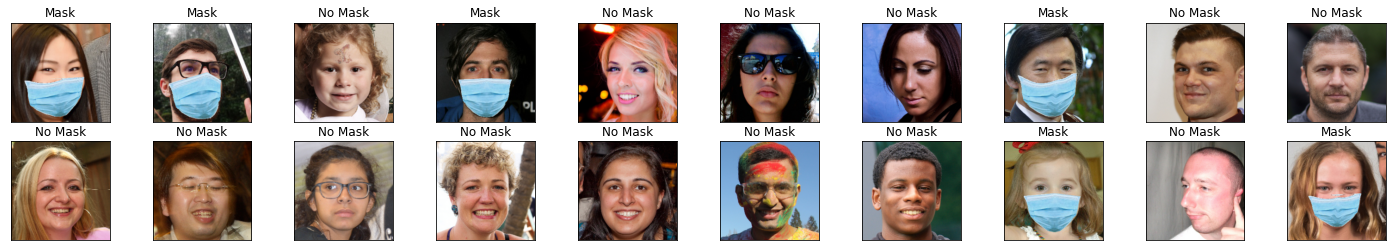

In [97]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1, shuffle=True)
display_data(train_data)

#### Check Our Validation Data

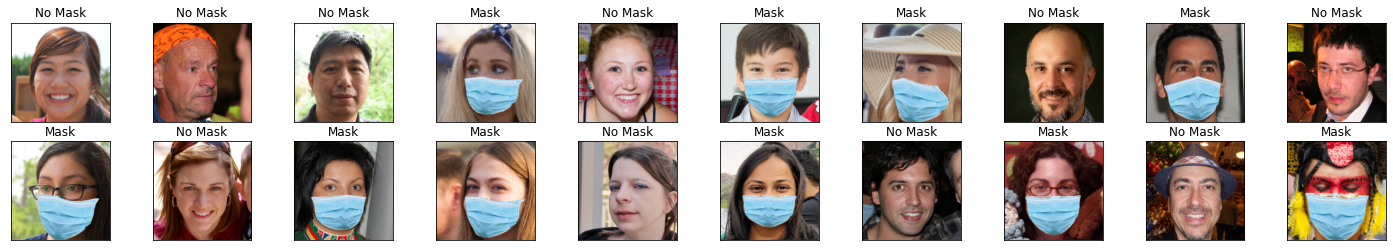

In [98]:
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1, shuffle=True)
display_data(val_data)

#### Check Our Test Data

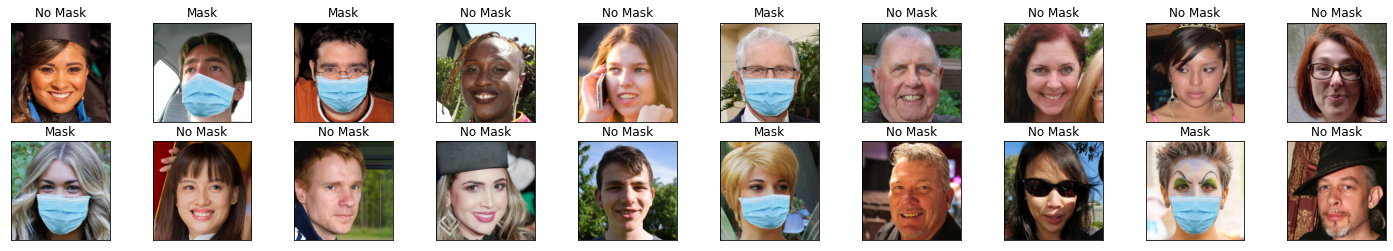

In [99]:
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1, shuffle=True)
display_data(test_data)

## Baseline Model
blah blah

## Basic CNN Model - Version 1
This is the basic CNN version model, description blah blah


In [100]:
class Basic_CNN(nn.Module):
    # 7 layers: 2 conv, 2 max pool, 2 linear, 1 output
    def __init__(self):
        self.name = "Basic_CNN"
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img))) #relu activation function
        x = self.pool(F.relu(self.conv2(x))) #relu activation function
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x)) #relu activation function
        x = self.fc2(x)
        return x

In [101]:
def get_accuracy(model, data_loader):
    '''
    Gets Correct/total
    
    Model: The CNN Model
    
    data_loader: torch dataloader
    '''
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [106]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    torch.manual_seed(1000)
    #Load data
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print("Done loading data")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    print ("Starting to train...")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        print("Epoch #: {0} Accuracy: {1}".format(epoch+1, train_acc[epoch]))
        
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 1 Accuracy: 0.9944657300979141
Epoch #: 2 Accuracy: 0.9978714346530438
Epoch #: 3 Accuracy: 0.998297147722435
Epoch #: 4 Accuracy: 0.998297147722435
Epoch #: 5 Accuracy: 0.998297147722435
Epoch #: 6 Accuracy: 0.998297147722435
Epoch #: 7 Accuracy: 0.998297147722435
Epoch #: 8 Accuracy: 0.998297147722435
Epoch #: 9 Accuracy: 0.998297147722435
Epoch #: 10 Accuracy: 0.998297147722435


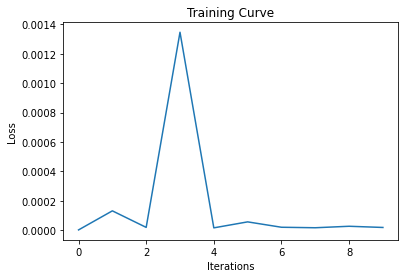

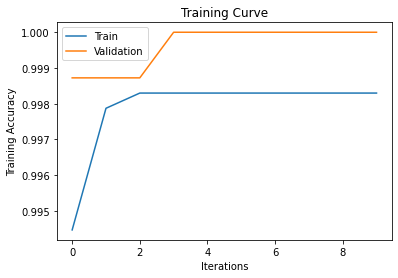

Final Training Accuracy: 0.998297147722435
Final Validation Accuracy: 1.0


In [113]:
use_cuda = True
model = Basic_CNN()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 64, learning_rate = 0.005, num_epochs = 10)

In [115]:
#Test
best_model = Basic_CNN()
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("Basic_CNN", 64, 0.005, 5)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("test accuracy:", test_accuracy)

test accuracy: 0.9987244897959183


In [ ]:
#Weird? ^